## Importing Libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting

from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shutil
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Libraries for get_images function
import matplotlib.image as mpimg
from skimage.transform import resize

import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import layers, models, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras import Input

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

## Creating Directories

In [2]:
images_dir = "./Data/images2/Images"
annotations_dir = "./Data/annotations/Annotation"
output_dir = "./Data/Datasets"

## Train/Test Split

In [3]:
def copy_files(breed, image_file, image_dir, annotation_dir, dest_images_folder, dest_annotations_folder):
    """Copy image and corresponding annotation files to the destination folder."""
    annotation_file = image_file.replace(".jpg", "")
    image_path = os.path.join(image_dir, image_file)
    annotation_path = os.path.join(annotation_dir, annotation_file)
    if not os.path.exists(image_path):
        print(f"Missing image: {image_path}")
        return
    if not os.path.exists(annotation_path):
        print(f"Missing annotation: {annotation_path}")
        return

    # Create destination folders for the breed
    os.makedirs(os.path.join(dest_images_folder, breed), exist_ok=True)
    os.makedirs(os.path.join(dest_annotations_folder, breed), exist_ok=True)
    shutil.copy(image_path, os.path.join(dest_images_folder, breed, image_file))
    shutil.copy(annotation_path, os.path.join(dest_annotations_folder, breed, annotation_file))

In [4]:

def split_dataset(images_folder, annotations_folder, output_folder, test_size=0.2, val_size=0.2, random_state=42):
    """
    Split the dataset of images and annotations into train, val, and test sets.

    Args:
        images_folder (str): Path to the folder containing images organized by class.
        annotations_folder (str): Path to the folder containing annotation files organized by class.
        output_folder (str): Path to save the split dataset (train/val/test for images and annotations).
        test_size (float): Proportion of the dataset to include in the test set.
        val_size (float): Proportion of the training data to use for validation.
        random_state (int): Random seed for reproducibility.
    """
    # Paths for train/val/test splits
    train_images_folder = os.path.join(output_folder, "train", "images")
    val_images_folder = os.path.join(output_folder, "val", "images")
    test_images_folder = os.path.join(output_folder, "test", "images")
    train_annotations_folder = os.path.join(output_folder, "train", "annotations")
    val_annotations_folder = os.path.join(output_folder, "val", "annotations")
    test_annotations_folder = os.path.join(output_folder, "test", "annotations")

    # Remove existing train/val/test folders if they exist
    for folder in [train_images_folder, val_images_folder, test_images_folder,
                   train_annotations_folder, val_annotations_folder, test_annotations_folder]:
        if os.path.exists(folder):
            shutil.rmtree(folder)
            
    # Create output directories
    os.makedirs(train_images_folder, exist_ok=True)
    os.makedirs(val_images_folder, exist_ok=True)
    os.makedirs(test_images_folder, exist_ok=True)
    os.makedirs(train_annotations_folder, exist_ok=True)
    os.makedirs(val_annotations_folder, exist_ok=True)
    os.makedirs(test_annotations_folder, exist_ok=True)

    # Process each breed
    for breed in os.listdir(images_folder):
        breed_images_dir = os.path.join(images_folder, breed)
        breed_annotations_dir = os.path.join(annotations_folder, breed)

        # Skip if not a directory
        if not os.path.isdir(breed_images_dir) or not os.path.isdir(breed_annotations_dir):
            print(f"Skipping non-directory: {breed}")
            continue

        # Get all images
        images = [f for f in os.listdir(breed_images_dir) if f.endswith(".jpg")]

        if not images:
            print(f"No images found in: {breed_images_dir}")
            continue

        # Split into train + val and test
        train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=random_state)
        # Split train + val into train and val
        train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=random_state)

        # Copy train images and annotations
        for image_file in train_images:
            copy_files(breed, image_file, breed_images_dir, breed_annotations_dir, train_images_folder, train_annotations_folder)

        # Copy val images and annotations
        for image_file in val_images:
            copy_files(breed, image_file, breed_images_dir, breed_annotations_dir, val_images_folder, val_annotations_folder)

        # Copy test images and annotations
        for image_file in test_images:
            copy_files(breed, image_file, breed_images_dir, breed_annotations_dir, test_images_folder, test_annotations_folder)

    print(f"Dataset split into train, val, and test sets. Saved to: {output_folder}")


In [5]:
split_dataset(images_dir, annotations_dir, output_dir)

Skipping non-directory: .DS_Store
Dataset split into train, val, and test sets. Saved to: ./Data/Datasets


## Resizing Image

In [6]:
def resize_images(input_folder, output_folder, target_size=(224, 224)):
    """
    Resize images to the target size while maintaining aspect ratio with padding.

    Args:
        input_folder (str): Path to the input folder containing images organized by class.
        output_folder (str): Path to save resized images.
        target_size (tuple): Target size as (width, height).
    """
    # Remove the existing output folder if it exists
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)

    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.endswith(".jpg"):
                input_path = os.path.join(root, file)
                output_path = os.path.join(output_folder, os.path.relpath(input_path, input_folder))
                
                # Create output directories if they don't exist
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                # Open the image
                with Image.open(input_path) as img:
                    # Resize image with padding
                    img_resized = ImageOps.fit(img, target_size, method=Image.LANCZOS, centering=(0.5, 0.5))
                    img_resized.save(output_path)

                print(f"Resized and saved: {output_path}")


In [7]:
input_folder = "./Data/Datasets/train/images"
output_folder = "./Data/Resized/train/images"
resize_images(input_folder, output_folder, target_size=(224, 224))

Resized and saved: ./Data/Resized/train/images/n02091244-Ibizan_hound/n02091244_2782.jpg
Resized and saved: ./Data/Resized/train/images/n02091244-Ibizan_hound/n02091244_1076.jpg
Resized and saved: ./Data/Resized/train/images/n02091244-Ibizan_hound/n02091244_5238.jpg
Resized and saved: ./Data/Resized/train/images/n02091244-Ibizan_hound/n02091244_2542.jpg
Resized and saved: ./Data/Resized/train/images/n02091244-Ibizan_hound/n02091244_5601.jpg
Resized and saved: ./Data/Resized/train/images/n02091244-Ibizan_hound/n02091244_1856.jpg
Resized and saved: ./Data/Resized/train/images/n02091244-Ibizan_hound/n02091244_110.jpg
Resized and saved: ./Data/Resized/train/images/n02091244-Ibizan_hound/n02091244_448.jpg
Resized and saved: ./Data/Resized/train/images/n02091244-Ibizan_hound/n02091244_2742.jpg
Resized and saved: ./Data/Resized/train/images/n02091244-Ibizan_hound/n02091244_716.jpg
Resized and saved: ./Data/Resized/train/images/n02091244-Ibizan_hound/n02091244_2838.jpg
Resized and saved: ./Dat

In [8]:
input_folder_val = "./Data/Datasets/val/images"
output_folder_val = "./Data/Resized/val/images"
resize_images(input_folder_val, output_folder_val, target_size=(224, 224))

Resized and saved: ./Data/Resized/val/images/n02091244-Ibizan_hound/n02091244_5774.jpg
Resized and saved: ./Data/Resized/val/images/n02091244-Ibizan_hound/n02091244_879.jpg
Resized and saved: ./Data/Resized/val/images/n02091244-Ibizan_hound/n02091244_5818.jpg
Resized and saved: ./Data/Resized/val/images/n02091244-Ibizan_hound/n02091244_3075.jpg
Resized and saved: ./Data/Resized/val/images/n02091244-Ibizan_hound/n02091244_2747.jpg
Resized and saved: ./Data/Resized/val/images/n02091244-Ibizan_hound/n02091244_3921.jpg
Resized and saved: ./Data/Resized/val/images/n02091244-Ibizan_hound/n02091244_1265.jpg
Resized and saved: ./Data/Resized/val/images/n02091244-Ibizan_hound/n02091244_1714.jpg
Resized and saved: ./Data/Resized/val/images/n02091244-Ibizan_hound/n02091244_1072.jpg
Resized and saved: ./Data/Resized/val/images/n02091244-Ibizan_hound/n02091244_5943.jpg
Resized and saved: ./Data/Resized/val/images/n02091244-Ibizan_hound/n02091244_4031.jpg
Resized and saved: ./Data/Resized/val/images

In [9]:
input_folder_test = "./Data/Datasets/test/images"
output_folder_test = "./Data/Resized/test/images"
resize_images(input_folder_test, output_folder_test, target_size=(224, 224))

Resized and saved: ./Data/Resized/test/images/n02091244-Ibizan_hound/n02091244_4669.jpg
Resized and saved: ./Data/Resized/test/images/n02091244-Ibizan_hound/n02091244_4086.jpg
Resized and saved: ./Data/Resized/test/images/n02091244-Ibizan_hound/n02091244_6041.jpg
Resized and saved: ./Data/Resized/test/images/n02091244-Ibizan_hound/n02091244_5038.jpg
Resized and saved: ./Data/Resized/test/images/n02091244-Ibizan_hound/n02091244_5400.jpg
Resized and saved: ./Data/Resized/test/images/n02091244-Ibizan_hound/n02091244_3707.jpg
Resized and saved: ./Data/Resized/test/images/n02091244-Ibizan_hound/n02091244_5982.jpg
Resized and saved: ./Data/Resized/test/images/n02091244-Ibizan_hound/n02091244_3289.jpg
Resized and saved: ./Data/Resized/test/images/n02091244-Ibizan_hound/n02091244_4268.jpg
Resized and saved: ./Data/Resized/test/images/n02091244-Ibizan_hound/n02091244_2427.jpg
Resized and saved: ./Data/Resized/test/images/n02091244-Ibizan_hound/n02091244_1000.jpg
Resized and saved: ./Data/Resize

## Preparing Datasets

In [10]:
# Set paths
train_dir = "./Data/Resized/train/images"
val_dir = "./Data/Resized/val/images"
test_dir = "./Data/Resized/test/images"

In [11]:
# Image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [12]:
# Create a data generator for the test set
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load the test dataset
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important to keep order for evaluation
)


# Data generator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,       # Normalize pixel values
    rotation_range=10,     # Random rotation
    width_shift_range=0.1, # Horizontal shift
    height_shift_range=0.1,# Vertical shift
    shear_range=0.1,       # Shearing transformation
    zoom_range=0.1,        # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'    # Fill in gaps created by augmentation
)

# Data generator for validation (no augmentation, just normalization)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# # Load the training dataset
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # For multi-class classification
    shuffle=True,
               # Shuffle training data
)

# # Load the validation dataset
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # For multi-class classification
    shuffle=True,
                                # No shuffling for validation data
)

Found 483 images belonging to 14 classes.
Found 1518 images belonging to 14 classes.
Found 385 images belonging to 14 classes.


In [13]:
steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = val_data.samples // val_data.batch_size

## Model 1: Simplest

In [13]:
model = Sequential([
    Input(shape=(224, 224, 3)), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Regularization
    Dense(14, activation='softmax')  
])

In [14]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.0001))


In [ ]:
model.summary()

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # Train longer
    callbacks=[early_stopping]
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.0753 - loss: 2.6729 - val_accuracy: 0.1403 - val_loss: 2.5616
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.1305 - loss: 2.5476 - val_accuracy: 0.2519 - val_loss: 2.3931
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.1628 - loss: 2.4463 - val_accuracy: 0.2701 - val_loss: 2.2326
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - accuracy: 0.2057 - loss: 2.3234 - val_accuracy: 0.2753 - val_loss: 2.1056
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.2328 - loss: 2.2495 - val_accuracy: 0.3195 - val_loss: 2.0502
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.2784 - loss: 2.1786 - val_accuracy: 0.3558 - val_loss: 1.9526
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 256ms/step - accuracy: 0.3072 - loss: 2.0929 - val_accuracy: 0.3896 - val_loss: 1.9687
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.2762 - loss: 2.1273 - val_accu

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
                               precision    recall  f1-score   support

n02087394-Rhodesian_ridgeback       0.36      0.41      0.39        29
             n02090622-borzoi       0.15      0.06      0.09        31
       n02091244-Ibizan_hound       0.42      0.50      0.46        38
 n02091467-Norwegian_elkhound       0.38      0.50      0.43        40
 n02093859-Kerry_blue_terrier       0.55      0.50      0.52        36
   n02095889-Sealyham_terrier       0.57      0.61      0.59        41
 n02096294-Australian_terrier       0.44      0.42      0.43        40
        n02096585-Boston_bull       0.42      0.46      0.44        37
n02102973-Irish_water_spaniel       0.48      0.53      0.51        30
        n02105056-groenendael       0.39      0.37      0.38        30
           n02105505-komondor       0.45      0.55      0.49        31
       n02108422-bull_mastiff       0.23      0.09      0.13        32
            n02111889-Samoyed       

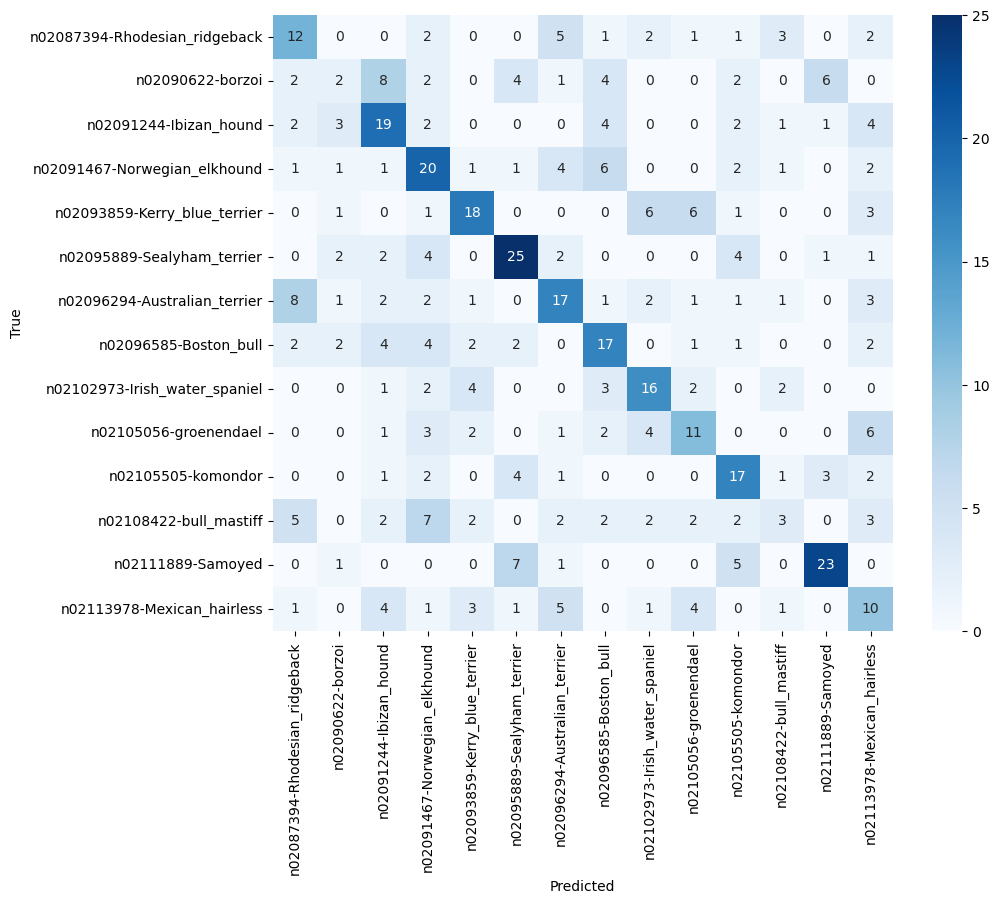

In [17]:
# Predict on validation data
test_predictions = model.predict(test_data)
predicted_classes = np.argmax(test_predictions, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Model 2

In [16]:
model2 = Sequential([
    Input(shape=(224, 224, 3)), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),  # Add more layers
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),  # Increase units in Dense layer
    Dropout(0.5),
    Dense(14, activation='softmax')
])

In [17]:
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.0001),)


In [18]:
early_stopping2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history2 = model2.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Train longer
    callbacks=[early_stopping2]
)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 309ms/step - accuracy: 0.0839 - loss: 2.6455 - val_accuracy: 0.1948 - val_loss: 2.5187
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - accuracy: 0.1763 - loss: 2.4612 - val_accuracy: 0.3039 - val_loss: 2.2116
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - accuracy: 0.2311 - loss: 2.2677 - val_accuracy: 0.3195 - val_loss: 2.0686
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 329ms/step - accuracy: 0.2616 - loss: 2.1712 - val_accuracy: 0.3766 - val_loss: 1.9355
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - accuracy: 0.2948 - loss: 2.0479 - val_accuracy: 0.3740 - val_loss: 1.9163
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 317ms/step - accuracy: 0.3068 - loss: 2.0121 - val_accuracy: 0.4130 - val_loss: 1.8393
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 318ms/step - accuracy: 0.3205 - loss: 1.9431 - val_accuracy: 0.4052 - val_loss: 1.8263
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 318ms/step - accuracy: 0.3459 - loss: 1.9297 - val_accu

KeyboardInterrupt: 

In [ ]:
# Plot accuracy
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on validation data
test_predictions2 = model2.predict(test_data)
predicted_classes2 = np.argmax(test_predictions2, axis=1)
true_classes2 = test_data.classes
class_labels2 = list(test_data.class_indices.keys())

# Classification report
print(classification_report(true_classes2, predicted_classes2, target_names=class_labels2))

# Confusion matrix
cm = confusion_matrix(true_classes2, predicted_classes2)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels2, yticklabels=class_labels2, cmap='Blues')
plt.xlabel('Predicted2')
plt.ylabel('True2')
plt.show()

## Model 3

In [28]:
model3 = Sequential([
    Input(shape=(224, 224, 3)),  # Explicitly define input shape here
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(14, activation='softmax')
])

In [29]:
model3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.0001),)


In [30]:

early_stopping3 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history3 = model3.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Train longer
    callbacks=[early_stopping3]
)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 504ms/step - accuracy: 0.1908 - loss: 4.1418 - val_accuracy: 0.0805 - val_loss: 4.2175
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 508ms/step - accuracy: 0.5186 - loss: 1.5212 - val_accuracy: 0.0779 - val_loss: 7.2790
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 506ms/step - accuracy: 0.6831 - loss: 1.0000 - val_accuracy: 0.0779 - val_loss: 8.9829
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 509ms/step - accuracy: 0.7967 - loss: 0.6212 - val_accuracy: 0.0779 - val_loss: 9.2793
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 503ms/step - accuracy: 0.8898 - loss: 0.3826 - val_accuracy: 0.0779 - val_loss: 8.6093
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 500ms/step - accuracy: 0.9132 - loss: 0.2772 - val_accuracy: 0.0883 - val_loss: 6.7177


In [ ]:
# Predict on validation data
test_predictions3 = model3.predict(test_data)
predicted_classes3 = np.argmax(test_predictions3, axis=1)
true_classes3 = test_data.classes
class_labels3 = list(test_data.class_indices.keys())

# Classification report
print(classification_report(true_classes3, predicted_classes3, target_names=class_labels3))

# Confusion matrix
cm = confusion_matrix(true_classes3, predicted_classes3)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels3, yticklabels=class_labels3, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Model 4: VGG16

In [31]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model4 = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replace Flatten for efficiency
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout for regularization
    Dense(14, activation='softmax')  # Output layer for 14 classes
])

# Compile the model
model4.compile(
    optimizer=Adam(learning_rate=1e-5),  # Smaller learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model4.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,614 (56.65 MB)

 Trainable params: 134,926 (527.05 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
# Early stopping callback
early_stopping4 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history4 = model4.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE,
    callbacks=[early_stopping4]
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.0566 - loss: 3.0740 - val_accuracy: 0.0625 - val_loss: 2.8609
Epoch 2/20
 1/47 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.0625 - loss: 2.9642

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 327ms/step - accuracy: 0.0625 - loss: 2.9642 - val_accuracy: 0.0625 - val_loss: 2.8591
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.0730 - loss: 2.9927 - val_accuracy: 0.0625 - val_loss: 2.8069
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - accuracy: 0.0938 - loss: 2.9765 - val_accuracy: 0.0625 - val_loss: 2.8069
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.0681 - loss: 2.9239 - val_accuracy: 0.0599 - val_loss: 2.7679
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 312ms/step - accuracy: 0.0625 - loss: 2.9637 - val_accuracy: 0.0625 - val_loss: 2.7654
Epoch 7/20
 5/47 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.0601 - loss: 2.8362

KeyboardInterrupt: 

In [ ]:
# Predict on validation data
test_predictions4 = model4.predict(test_data)
predicted_classes4 = np.argmax(test_predictions4, axis=1)
true_classes4 = test_data.classes
class_labels4 = list(test_data.class_indices.keys())

# Classification report
print(classification_report(true_classes4, predicted_classes4, target_names=class_labels4))

# Confusion matrix
cm = confusion_matrix(true_classes4, predicted_classes4)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels4, yticklabels=class_labels4, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:

# Find misclassified indices
misclassified_indices = [i for i in range(len(true_classes4)) if true_classes4[i] != predicted_classes4[i]]

# Display a few misclassified images
for i in misclassified_indices[:]:  # Show first 5 misclassified images
    image_path = test_data.filepaths[i]
    true_label = class_labels4[true_classes4[i]]
    predicted_label = class_labels4[predicted_classes4[i]]

    # Load and display the image
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()